In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True, )

from generate_training_validation_data import CustomImageDataset
from Custom_small_FCN import FCN4s

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import cv2 as cv

from collections import namedtuple
from typing import Any
import torch
import torch.optim as optim
import torch.nn as nn
from torchfcn.models import FCN8sAtOnce, VGG16, FCN8s, FCN16s, FCN32s
from torchfcn.models.fcn32s import get_upsampling_weight



In [2]:

class LeakyFCN8sAtOnce(FCN8sAtOnce):
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.zero_()
                torch.nn.init.xavier_uniform(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
                    torch.nn.init.xavier_uniform(m.bias)

            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)


    def __init__(self, n_class=21):
        super(FCN8sAtOnce, self).__init__()
        # conv1
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.LeakyReLU(negative_slope=0.03,inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.LeakyReLU(negative_slope=0.03,inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/2

        # conv2
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.LeakyReLU(negative_slope=0.03,inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.LeakyReLU(negative_slope=0.03,inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/4

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.LeakyReLU(negative_slope=0.03,inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.LeakyReLU(negative_slope=0.03,inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.LeakyReLU(negative_slope=0.03,inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/8

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.LeakyReLU(negative_slope=0.03,inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.LeakyReLU(negative_slope=0.03,inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.LeakyReLU(negative_slope=0.03,inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/16

        # conv5
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.LeakyReLU(negative_slope=0.03,inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.LeakyReLU(negative_slope=0.03,inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.LeakyReLU(negative_slope=0.03,inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/32

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.LeakyReLU(negative_slope=0.03,inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.LeakyReLU(negative_slope=0.03,inplace=True)
        self.drop7 = nn.Dropout2d()

        self.score_fr = nn.Conv2d(4096, n_class, 1)
        self.score_pool3 = nn.Conv2d(256, n_class, 1)
        self.score_pool4 = nn.Conv2d(512, n_class, 1)

        self.upscore2 = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)
        self.upscore8 = nn.ConvTranspose2d(
            n_class, n_class, 16, stride=8, bias=False)
        self.upscore_pool4 = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)

        self._initialize_weights()



In [3]:

train_data_dir = 'D:/MemeMachine_ProjectData/dataset/training'
validation_data_dir = 'D:/MemeMachine_ProjectData/dataset/validation'
img_width, img_height, n_channels = 1020, 1020, 3 #TODO change dimensions to be wider, to better support text

epochs = 1 #50 TODO
batch_size = 1
classes = ['nothing', 'text']

# model = FCN32s(n_class=len(classes))

# vgg16 = VGG16(pretrained=True)
# model.copy_params_from_vgg16(vgg16)

model = FCN8s()
pretrained_model = model.download()
model.load_state_dict(torch.load(pretrained_model))

# classes = ['text']


#change the number of classes in the final step of the classifier
# #print(model.classifier[4])
# model.classifier[4] = torch.nn.Conv2d(512, len(classes), kernel_size=(1,1), stride = (1,1))
# torch.nn.init.xavier_uniform(model.classifier[4].weight)

# # #print(model.aux_classifier[4])
# model.aux_classifier[4] = torch.nn.Conv2d(256, len(classes), kernel_size=(1,1), stride = (1,1))
# torch.nn.init.xavier_uniform(model.aux_classifier[4].weight)

model.eval()

[C:\Users\maxan/data/models/pytorch/fcn8s_from_caffe.pth] Checking md5 (de93e540ec79512f8770033849c8ae89)


FCN8s(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
  (relu1_1): ReLU(inplace=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU(inplace=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU(inplace=True)
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU(inplace=True)
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU(inplace=True)
  (pool3): MaxPool2d(kernel_size=2

In [4]:
experiment_name = "Test38_1_pytorch-fcn_FCN8s_Adam" 

In [5]:
torch.backends.cudnn.benchmark = True


"""             CUDA Troubleshooting            """

def get_parameters(model, bias=False):
    import torch.nn as nn
    modules_skipped = (
        nn.ReLU,
        nn.LeakyReLU,
        nn.MaxPool2d,
        nn.Dropout2d,
        nn.Sequential,
        FCN32s,
        FCN16s,
        FCN8s,
    )
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            if bias:
                yield m.bias
            else:
                yield m.weight
        elif isinstance(m, nn.ConvTranspose2d):
            # weight is frozen because it is just a bilinear upsampling
            if bias:
                assert m.bias is None
        elif isinstance(m, modules_skipped):
            continue
        else:
            raise ValueError('Unexpected module: %s' % str(m))




All pre-trained models expect input images normalized in the same way,
i.e. mini-batches of 3-channel RGB images of shape `(N, 3, H, W)`, where `N` is the number of images, `H` and `W` are expected to be at least `224` pixels.
The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]`
and `std = [0.229, 0.224, 0.225]`.

The model returns an `OrderedDict` with two Tensors that are of the same height and width as the input Tensor, but with 21 classes.
`output['out']` contains the semantic masks, and `output['aux']` contains the auxillary loss values per-pixel. In inference mode, `output['aux']` is not useful.
So, `output['out']` is of shape `(N, 21, H, W)`. More documentation can be found [here](https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


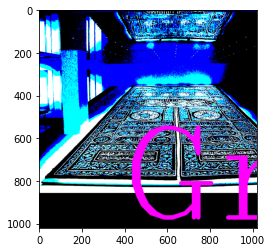

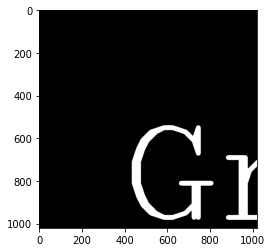

In [6]:
import optuna

# Select an image from the dataset

#TODO change image_with_text_functions.generate_text_on_image_and_pixel_mask_from_path to place the text properly
train_dataset = CustomImageDataset(train_data_dir, img_width, img_height)
test_dataset = CustomImageDataset(validation_data_dir, img_width, img_height)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Display image and label
train_features, train_labels = next(iter(train_dataloader))
#print(f"Feature batch shape: {train_features.size()}")
#print(f"Labels batch shape: {train_labels.size()}")
input_image = train_features[0].squeeze()
input_image = np.moveaxis(input_image.numpy(), 0, -1)
label = train_labels[0].reshape((img_width, img_height))

plt.imshow(input_image, cmap="gray")
plt.show()
plt.imshow(label, cmap="gray")
plt.show()

The output here is of shape `(21, H, W)`, and at each location, there are unnormalized probabilities corresponding to the prediction of each class.
To get the maximum prediction of each class, and then use it for a downstream task, you can do `output_predictions = output.argmax(0)`.

Here's a small snippet that plots the predictions, with each color being assigned to each class (see the visualized image on the left).

### Model Description

FCN-ResNet is constructed by a Fully-Convolutional Network model, using a ResNet-50 or a ResNet-101 backbone.
The pre-trained models have been trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.

Their accuracies of the pre-trained models evaluated on COCO val2017 dataset are listed below.

| Model structure |   Mean IOU  | Global Pixelwise Accuracy |
| --------------- | ----------- | --------------------------|
|  fcn_resnet50   |   60.5      |   91.4                    |
|  fcn_resnet101  |   63.7      |   91.9                    |

### Resources

 - [Fully Convolutional Networks for Semantic Segmentation](https://arxiv.org/abs/1605.06211)

In [7]:

# # pylint: disable = abstract-method
# class ModelWrapper(torch.nn.Module):
#     """
#     Wrapper class for model with dict/list rvalues.
#     """

#     def __init__(self, model: torch.nn.Module) -> None:
#         """
#         Init call.
#         """
#         super().__init__()
#         self.model = model

#     def forward(self, input_x: torch.Tensor) -> Any:
#         """
#         Wrap forward call.
#         """
#         data = self.model(input_x)

#         if isinstance(data, dict):
#             data_named_tuple = namedtuple("ModelEndpoints", sorted(data.keys()))  # type: ignore
#             data = data_named_tuple(**data)  # type: ignore

#         elif isinstance(data, list):
#             data = tuple(data)

#         return data

In [8]:
from torch.utils.tensorboard import SummaryWriter
# # default `log_dir` is "runs" - we'll be more specific here
# writer = SummaryWriter('runs/FCN_resnet101_GPU_text_pixel_masking/'+experiment_name) 

# # get some random training images
# dataiter = iter(train_dataloader)
# images, labels = dataiter.next()

# # create grid of images
# img_grid = torchvision.utils.make_grid(images)

# # write to tensorboard
# writer.add_image('FCN_resnet101_GPU_text_pixel_masking_images', img_grid)

# model_wrapper = ModelWrapper(model)
# writer = SummaryWriter('runs/FCN_resnet101_GPU_text_pixel_masking/'+experiment_name) 

# writer.add_graph(model_wrapper, torch.tensor(images))
# writer.close()


def plot_classes_preds(images, preds, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''

    images = images.detach().cpu().numpy().squeeze()
    print(images.shape)
    images = images.transpose((1,2,0))



    fig = plt.figure(figsize=(30, 15))

    fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
    input_image = images.squeeze()
    # #print('input_image', input_image.shape)
    plt.imshow(input_image)

    fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
    plt.imshow(preds.reshape((img_height,img_width)).detach().cpu().numpy(), cmap='gray')

    fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
    label = labels.reshape((img_width, img_height)).long().detach().cpu()
    plt.imshow(label, cmap='gray')


    return fig

In [9]:


#'model_saves/'+experiment_name+".pytorch_model"

preprocess = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def validate(num_samples, criterion, writer, epoch, optimizer):
    best_val_loss = 0
    # Validation

    val_loss = 0.0
    val_steps = 0
    for i, data in enumerate(test_dataloader, 0):
        if i > num_samples:
            break
        with torch.no_grad():
            inputs, labels = data
            inputs = inputs.squeeze()
            inputs = np.moveaxis(inputs.detach().cpu().numpy(), 0, -1)
            preprocessed_inputs = cv.cvtColor(inputs, cv.COLOR_BGR2RGB)
            preprocessed_inputs = Image.fromarray(np.uint8(preprocessed_inputs))
            preprocessed_inputs = preprocessed_inputs.convert("RGB")
            preprocessed_inputs = preprocess(preprocessed_inputs)
            preprocessed_inputs = preprocessed_inputs.unsqueeze(0)

            # move the input and model to GPU for speed if available
            if torch.cuda.is_available():
                preprocessed_inputs = preprocessed_inputs.to('cuda')
                labels = labels.to('cuda')

            # forward + backward + optimize
            output = model(preprocessed_inputs)[0]
            output = nn.Softmax(dim=0)(output)
            output = output[1] - output[0]
            output = torch.unsqueeze(output, 0)
            output = torch.unsqueeze(output, 0)
            labels = torch.reshape(labels, (1, img_height,img_width))
            labels[labels<=0] = -1
            labels[labels>0] = 1
            labels = labels.long()

            loss = criterion(output, labels)
            val_loss += loss.cpu().numpy()    
            val_steps += 1

        if i % 1000 == 999:    # #print every 1000 mini-batches
            #print(i)
            #print("val loss", val_loss/val_steps)
            writer.add_scalar('average mini-epoch validation loss',
                val_loss/val_steps,
                val_steps)

    writer.add_scalar('average validation loss',
            val_loss / val_steps,
            epoch)

    if val_loss / val_steps < best_val_loss:
        #print("New best model by validation loss!")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'model_saves/'+experiment_name+"_"+str(int(best_val_loss))+".pytorch_model")
        best_val_loss = val_loss / val_steps
        with open("model_saves\\best_val_loss.txt", 'a') as best_val_loss_fh:
            best_val_loss_fh.write(str(int(best_val_loss))+"\n")
        with open("model_saves\\best_model.txt", 'a') as best_val_loss_fh:
            best_val_loss_fh.write('model_saves/'+experiment_name+"_"+str(int(best_val_loss))+".pytorch_model\n")


In [10]:
def objective(trial, model):
    
    writer = SummaryWriter('runs/FCN_resnet101_GPU_text_pixel_masking/'+experiment_name)#+"/"+str(trial.number)) 

    # criterion = nn.CrossEntropyLoss(size_average=False, reduction='sum')
    criterion = nn.SoftMarginLoss(reduction='sum')
    # criterion = nn.HingeEmbeddingLoss(margin=1.0, reduction='sum')
    # optimizer = optim.SGD(model.parameters(), lr=10**-4, momentum=0.99)

    # optimizer = torch.optim.SGD(
    #     [
    #         {'params': get_parameters(model, bias=False)},
    #         {'params': get_parameters(model, bias=True),
    #          'lr':(10**-10)* 2, 'weight_decay': 0},
    #     ],
    #     lr=(10**-10),
    #     momentum=0.99)
    if torch.cuda.is_available():
        model.to('cuda')
    
    # optimizer = optim.Adam(model.parameters())
        optimizer = torch.optim.Adam(
        [
            {'params': get_parameters(model, bias=False)},
            {'params': get_parameters(model, bias=True),
             'lr': 0.006967112069996084, 'beta1': 0.006967112069996084, 'beta2': 0.9853718852556564},
        ])
    # Test 15 [I 2022-01-25 14:56:49,051] Trial 3 finished with value: 5567.529612823274 and parameters: {'lr': 6.630131189647407e-07, 'beta1': 0.006967112069996084, 'beta2': 0.9853718852556564}. Best is trial 3 with value: 5567.529612823274.
    # lr = trial.suggest_loguniform('lr', 10**-8, 10**-4)
    # beta1 = trial.suggest_loguniform('beta1', 1e-4, 1)
    # beta2 = trial.suggest_loguniform('beta2', 0.8, 0.999)
    # print("LR trial:", lr)
    # print("beta1 trial:", beta1)
    # print("beta2 trial:", beta2)

    # optimizer = optim.Adam(model.parameters(), lr=6.630131189647407e-07, betas=(0.006967112069996084, 0.9853718852556564), eps=10**-7) # decided by 5 trials (epochs) of hyperparameter tuning with Optuna
    # scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=10**-8, max_lr=10**-4, cycle_momentum=False)
    
    with open("model_saves\\best_model.txt", 'r') as best_model_fh:
            lines = best_model_fh.read().splitlines()
            if len(lines)>0:
                last_line = lines[-1]
                best_model_path = last_line
            else: 
                best_model_path = None
    if False:
        path = best_model_path
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        print("successfully loaded model checkpoint from", path)


    model.train()

    # Train the model
    last_epoch_loss = 0.0
    mini_epoch_loss = 0.0
    epoch_loss = 0.0
    for epoch in range(50):  # loop over the dataset multiple times  

        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # print(inputs.shape)

            # inputs = inputs.squeeze()
            # inputs = np.moveaxis(inputs.detach().cpu().numpy(), 0, -1)
            # # print(inputs.shape)
            # preprocessed_inputs = cv.cvtColor(inputs, cv.COLOR_BGR2RGB)
            # preprocessed_inputs = Image.fromarray(np.uint8(preprocessed_inputs))
            # preprocessed_inputs = preprocessed_inputs.convert("RGB")
            # preprocessed_inputs = preprocess(preprocessed_inputs)
            # preprocessed_inputs = preprocessed_inputs.unsqueeze(0)

            # move the input and model to GPU for speed if available
            if torch.cuda.is_available():
                preprocessed_inputs = inputs.to('cuda')
                labels = labels.to('cuda')
                model.to('cuda')
                

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            # output = model(preprocessed_inputs)['out'][0]
            output = model(preprocessed_inputs)
            print("raw_output1 max", torch.max(output))
            print("raw_output1 shape", output.shape)

            output = output[0]
            print("raw_output21 max", torch.max(output[0]))
            print("raw_output22 max", torch.max(output[1]))
            print("raw_output2 shape", output.shape)

            output = nn.Softmax(dim=0)(output)
            print("softmax_output max", torch.max(output))
            print("softmax_output min", torch.min(output))

            print("softmax_output[0] max", torch.max(output[0]))
            print("softmax_output[0] min", torch.min(output[0]))
            print("softmax_output[0] shape", output[0].shape)

            
            print("softmax_output[1] max", torch.max(output[1]))
            print("softmax_output[1] min", torch.min(output[1]))
            print("softmax_output[1] shape", output[1].shape)

            output = output[1] - output[0]
            output = torch.unsqueeze(output, 0)
            print("finaloutput", output)
            print("finalputput shape", output.shape)



            output = torch.unsqueeze(output, 0)
            labels = torch.reshape(labels, (1, img_height,img_width))
            labels[labels<=0] = -1
            labels[labels>0] = 1
            labels = labels.long()

            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()

            # print statistics
            epoch_loss += loss.item()
            mini_epoch_loss += loss.item()
            # if i % 1000 == 999:    # print every 1000 mini-batches
            # if i % 100 == 1:    # print every 100 mini-batches
            if i % 2 == 1:    # print every 2 mini-batches
                print(i)
                print("cost", loss)
                                  
                writer.add_scalar('average mini-epoch loss',
                    mini_epoch_loss / 1000,
                    epoch * len(train_dataloader) + i)

                mini_epoch_loss = 0.0
                writer.add_scalar('most recent cost',
                                loss.item(),
                                epoch * len(train_dataloader) + i)

                # ...log a Matplotlib Figure showing the model's predictions on a
                # random mini-batch
                writer.add_figure('input vs output vs label',
                                plot_classes_preds(inputs, output, labels),
                                global_step=epoch * len(train_dataloader) + i) 

            if i % 5000 == 4999:
            # if i % 1 == 0:
                validate(3000, criterion, writer, epoch, optimizer)

        writer.add_scalar('total epoch loss',
                        epoch_loss,
                        epoch * len(train_dataloader) + i)
        writer.add_scalar('average epoch loss',
                         epoch_loss / 
                        (epoch * len(train_dataloader) + i),
                        epoch * len(train_dataloader) + i)


        



    print('Finished Training')
    avg_epoch_loss = epoch_loss / (epoch * len(train_dataloader) + i)
    print("Average epoch loss of trial:", avg_epoch_loss)

    return avg_epoch_loss #average epoch loss



In [11]:
# study = optuna.create_study(direction='minimize', study_name=experiment_name)
# study.optimize(objective, n_trials=5)

objective(None, model)

    

raw_output1 max tensor(20.6640, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(20.6640, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(8.3896, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(6.0485e-12, device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(0.5468, device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0.3727, device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(4.0395e-10, device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-0.9917, -0.9935, -0.9952,  ..., -0.9996, -0.9997, -0.9997],
         [-0.9934, -0.9950, -0.9963,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1
cost tensor(662522.7500, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(310866.5000, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(310866.5000, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-2123.1738, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3
cost tensor(388495.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(80279832., device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(80279832., device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-1050989., device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..., -1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5
cost tensor(381040.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(1.8629e+09, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(1.8629e+09, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-24135072., device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ...,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7
cost tensor(363749.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(1.2846e+10, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(1.2846e+10, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-1.7817e+08, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9
cost tensor(406032.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(6.5636e+10, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(6.5636e+10, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-7.4852e+08, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11
cost tensor(339804.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(1.3859e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(1.3859e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-1.8248e+09, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13
cost tensor(335639.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(3.1576e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(3.1576e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-5.0560e+09, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15
cost tensor(327395.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(5.2823e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(5.2823e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-7.5377e+09, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17
cost tensor(341263.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(1.1014e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(1.1014e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-1.8657e+10, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19
cost tensor(369159.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(1.1478e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(1.1478e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-1.6600e+10, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21
cost tensor(353707.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(1.8504e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(1.8504e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-3.2824e+10, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23
cost tensor(414801.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(2.4395e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(2.4395e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-3.4883e+10, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25
cost tensor(349612.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(3.5546e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(3.5546e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-6.2727e+10, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


27
cost tensor(385547.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(4.5442e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(4.5442e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-4.9043e+10, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29
cost tensor(367371.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(4.7791e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(4.7791e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-7.5747e+10, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


31
cost tensor(364935.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(5.4706e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(5.4706e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-6.6727e+10, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


33
cost tensor(366395.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(5.9742e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(5.9742e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-1.2152e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


35
cost tensor(388160.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(9.3404e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(9.3404e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-9.4302e+10, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


37
cost tensor(412465.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(5.8762e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(5.8762e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-1.0176e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


39
cost tensor(364421.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(6.6877e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(6.6877e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-1.3911e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


41
cost tensor(385397.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(6.7532e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(6.7532e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-1.3546e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


43
cost tensor(349182.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(6.5920e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(6.5920e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-1.5923e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


45
cost tensor(380050.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(7.5786e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(7.5786e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-1.3521e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47
cost tensor(342435.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(9.1413e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(9.1413e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-1.3311e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


49
cost tensor(367086.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(7.4741e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(7.4741e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-5.9176e+10, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


51
cost tensor(405763.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(6.5273e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(6.5273e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-1.5262e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


53
cost tensor(341556.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(9.0488e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(9.0488e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-1.6941e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


55
cost tensor(360535.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(7.9409e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(7.9409e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-1.3318e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


57
cost tensor(367819.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(8.9260e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(8.9260e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-2.1474e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


59
cost tensor(380074.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(8.0453e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(8.0453e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-1.9481e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


61
cost tensor(414751.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(9.1915e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(9.1915e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-1.1192e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


63
cost tensor(391886.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(9.3105e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(9.3105e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-1.8221e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
cost tensor(358313.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(6.9302e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(6.9302e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-1.1118e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


67
cost tensor(368099.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(1.2672e+13, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(1.2672e+13, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-1.1243e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


69
cost tensor(357189.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(1.0392e+13, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(1.0392e+13, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-1.8497e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


71
cost tensor(349464.5000, device='cuda:0', grad_fn=<SoftMarginLossBackward0>)
(3, 1020, 1020)
raw_output1 max tensor(6.6361e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output1 shape torch.Size([1, 21, 1020, 1020])
raw_output21 max tensor(6.6361e+12, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output22 max tensor(-2.0651e+11, device='cuda:0', grad_fn=<MaxBackward1>)
raw_output2 shape torch.Size([21, 1020, 1020])
softmax_output max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] max tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[0] min tensor(1., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[0] shape torch.Size([1020, 1020])
softmax_output[1] max tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
softmax_output[1] min tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
softmax_output[1] shape torch.Size([1020, 1020])
finaloutput tensor([[[-1., -1., -1.,  ..

KeyboardInterrupt: 

In [ ]:
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    #print("Study statistics: ")
    #print("  Number of finished trials: ", len(study.trials))
    #print("  Number of pruned trials: ", len(pruned_trials))
    #print("  Number of complete trials: ", len(complete_trials))

    #print("Best trial:")
    trial = study.best_trial

    #print("  Value: ", trial.value)

    #print("  Params: ")
    for key, value in trial.params.items():
        #print("    {}: {}".format(key, value))

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Show a test of the newly trained (fine tuned) model below

In [ ]:
model.eval()

# Display image and label.
test_features, test_labels = next(iter(test_dataloader))
#print(f"Feature batch shape: {test_features.size()}")
#print(f"Labels batch shape: {test_labels.size()}")
input_image = test_features[0].squeeze()
input_image = np.moveaxis(input_image.numpy(), 0, -1)
label = test_labels[0].reshape((img_width, img_height))

plt.imshow(input_image, cmap="gray")
plt.show()
plt.imshow(label, cmap="gray")
plt.show()

In [ ]:
# input_image = Image.open(filename)
input_image2 = cv.cvtColor(input_image, cv.COLOR_BGR2RGB)
input_image2 = Image.fromarray(np.uint8(input_image2))
input_image2 = input_image2.convert("RGB")

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0] #zero refers to the batch number?
output_predictions = output.argmax(0)
#print(output_predictions)
#print(output_predictions.shape)
#print(output)
#print(output.shape)

In [ ]:
test(test_dataloader, model, criterion)